## **Carga de librerias y configuraciones**

In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import gzip

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri


In [2]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV'
data_file_name = "JAT_MCV_UNIVERSO_MODELOADO_FILTROS.csv"
header_file_name = 'JAT_MCV_UNIVERSO_MODELADO_PREVIO_labels.csv'
header = False

target = 'BMI'
# features =  ['pclass', 'age', 'sibsp', 'parch', 'fare']

# Decidimos si se desea imputar valores nulos con media, mediana o moda de las columnas
# en caso de no querer imputar debe tomarse en cuenta que este algoritmo no funciona con valores nulos
impute = True
strategy = 'mean'   # mean, meadian, most_frequent

# Decidimos si queremos escalar las columnas de caracteríticas de tal forma que posean una distribución normal
scale = True       



In [3]:
algorithm = 'xgboost'

# Configuramos los nombres de nuestra tarea de entrenamiento, configuración de servicio y servicio 
train_job = 'MCV-XGBoost-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
linear_endpoint_config = 'MCV-XGBoost-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
linear_endpoint = 'MCV-XGBoost-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())


# Hiperparámetros
hyperparameters = {
    "num_round": "100",                     # required
    "max_depth":"5",
    "eta":"0.1",    
    "objective": "binary:logistic",      
    "eval_metric": "auc",
    "nthread": "4",
    "seed": "1"
}


In [4]:
linear_endpoint

'MCV-XGBoost-endpoint-201808281714'

In [5]:
from subprocess import Popen, PIPE

command = 'cat /proc/meminfo'

lst = Popen(command, shell=True, stdout=PIPE).stdout.read()
for i in lst.split(b'\n'):
    print(i)

b'MemTotal:       32949048 kB'
b'MemFree:        30378116 kB'
b'MemAvailable:   31898228 kB'
b'Buffers:          672400 kB'
b'Cached:          1054444 kB'
b'SwapCached:            0 kB'
b'Active:          1562968 kB'
b'Inactive:         645432 kB'
b'Active(anon):     481576 kB'
b'Inactive(anon):       48 kB'
b'Active(file):    1081392 kB'
b'Inactive(file):   645384 kB'
b'Unevictable:           0 kB'
b'Mlocked:               0 kB'
b'SwapTotal:             0 kB'
b'SwapFree:              0 kB'
b'Dirty:                52 kB'
b'Writeback:            16 kB'
b'AnonPages:        481648 kB'
b'Mapped:           144408 kB'
b'Shmem:                60 kB'
b'Slab:             280480 kB'
b'SReclaimable:     257244 kB'
b'SUnreclaim:        23236 kB'
b'KernelStack:        3856 kB'
b'PageTables:         5852 kB'
b'NFS_Unstable:          0 kB'
b'Bounce:                0 kB'
b'WritebackTmp:          0 kB'
b'CommitLimit:    16474524 kB'
b'Committed_AS:    1896328 kB'
b'VmallocTotal:   34359738367 kB'
b'Vma

In [6]:
role = get_execution_role()

# ruta de trabajo en s3
bucket = 'boi-banregio'

# configuración de datos crudos
data_file_key = "{}/DATASETS/{}".format(prefix, data_file_name)
# configuración de datos crudos
header_file_key = "{}/DATASETS/{}".format(prefix, header_file_name)

# configuración de datos procesados
output_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/models/{}/".format(bucket, prefix, algorithm)
train_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/train/{}/".format(bucket, prefix, algorithm)
validation_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/validation/{}/".format(bucket, prefix, algorithm)
print(data_file_key)
print(header_file_key)

datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/JAT_MCV_UNIVERSO_MODELOADO_FILTROS.csv
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/JAT_MCV_UNIVERSO_MODELADO_PREVIO_labels.csv


In [7]:
#s3_client = boto3.client('s3')
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

#obj = s3_client.get_object(Bucket=bucket, Key=data_file_key)

obj = s3_bucket_resource.Object(data_file_key).get()

obj_header = s3_bucket_resource.Object(header_file_key).get()

df_header = pd.read_csv(io.BytesIO(obj_header['Body'].read()), header=None)

print(df_header.shape)

df = pd.read_csv(io.BytesIO(obj['Body'].read()), header=None, names=df_header.loc[0,:].values)



(1, 522)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,86,87,88,89,90,92,94,97,98,99,100,101,103,106,107,108,109,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [138]:
display(df.columns)
print(df.shape)
display(df.head())
display(df.describe())

Index(['LABEL', 'BMI', 'REVOLVENTE', 'CUR_BAL', 'MAX_BAL_03M', 'MIN_BAL_03M',
       'AVG_PND_MENOS_BAL_03M', 'AVG_PND_MAS_BAL_03M', 'AVG_BAL_03M',
       'MAX_BAL_06M',
       ...
       'AVG_AVG_HI_CALCAR_FLOOR_12M', 'AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M',
       'AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M',
       'AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M',
       'AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M',
       'AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M',
       'AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M', 'NUM_AVG_HI_CALCAR_FLOOR_03M',
       'NUM_AVG_HI_CALCAR_FLOOR_06M', 'NUM_AVG_HI_CALCAR_FLOOR_12M'],
      dtype='object', length=522)

(425287, 522)


,LABEL,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
0,7,0,1,2784,2784.00,2784.00,2784.000,2784.000,2784.000,2784.00,...,\N,\N,\N,\N,\N,\N,\N,0,0,0
1,7,0,1,4201.59,4201.59,4201.59,4201.590,4201.590,4201.590,4201.59,...,0.9,\N,0.2,0.07013,\N,0.085714,0.093506,0,1,1
2,7,0,1,5681.46,5681.46,4201.59,4694.880,5047.230,4941.525,5681.46,...,0.9,\N,0.2,0.07013,\N,0.085714,0.093506,0,1,1
3,7,0,1,1797.01,5681.46,1797.01,4904.570,2573.900,3739.235,5681.46,...,0.9,0.4,0.3,0.222078,0.15,0.3,0.268831,1,2,3
4,7,0,1,2.50414e+06,2514395.69,2018816.67,2362758.247,2410692.153,2386725.200,2530291.29,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,4,7,12


,LABEL,BMI,REVOLVENTE,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,NUM_PCT_VENC30M_12M,NUM_PCT_VENC60M_03M,NUM_PCT_VENC60M_06M,NUM_PCT_VENC60M_12M,NUM_MAX_HI_CALCAR_FLOOR_03M,NUM_MAX_HI_CALCAR_FLOOR_06M,NUM_MAX_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,425287.000000,425287.000000,425287.000000,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,...,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000
mean,6.862067,0.039333,0.766080,1.610967e+06,1.275978e+06,1.443487e+06,1.452581e+06,1.448332e+06,1.700662e+06,1.152317e+06,...,0.798141,0.171350,0.335632,0.577483,1.991888,3.997301,7.143289,1.992252,3.998102,7.145260
std,0.760168,0.194387,0.423322,2.215483e+06,1.916241e+06,2.036052e+06,2.049836e+06,2.038821e+06,2.289461e+06,1.793680e+06,...,2.298990,0.640663,1.208019,2.024245,1.345436,2.438943,4.279540,1.345326,2.438730,4.279556
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,1.000000,2.093648e+05,1.143822e+05,1.789757e+05,1.781050e+05,1.802155e+05,2.400379e+05,8.627984e+04,...,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,1.000000,2.000000,3.000000
50%,7.000000,0.000000,1.000000,7.043651e+05,4.900061e+05,5.994500e+05,6.018924e+05,6.031188e+05,7.713054e+05,4.267568e+05,...,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,9.000000,2.000000,5.000000,9.000000
75%,7.000000,0.000000,1.000000,2.074548e+06,1.588742e+06,1.878232e+06,1.888784e+06,1.883883e+06,2.190750e+06,1.430796e+06,...,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000,10.000000,3.000000,6.000000,10.000000
max,7.000000,1.000000,1.000000,3.504748e+07,2.004203e+07,2.005195e+07,2.006071e+07,2.005633e+07,4.106693e+07,2.001619e+07,...,12.000000,4.000000,7.000000,12.000000,4.000000,7.000000,12.000000,4.000000,7.000000,12.000000


In [8]:
df = df.replace(to_replace='\\N', value=np.nan)

# [target] + list(features)

In [9]:
features = list(df_header.iloc[0,range(2,522)].values)

In [10]:
removes = ['AMORTIZACIONEXIGIBLE', 'AMORTIZACIONNOEXIGIBLE', 'PAGOREALIZADO', 'VOLUNTADPAGO', 'VOLUNTADPAGOPERIODO']
for rm in removes:
    features.remove(rm)

len(features)

515

In [11]:
# select features and target if needed

df = df.loc[:, [target] + features]
# impute nans
if impute:
    imputer = prp.Imputer(missing_values='NaN', strategy=strategy, axis=0)
    imputer = imputer.fit(df.loc[:, features])
    df.loc[:, features] = imputer.transform(df.loc[:, features])

# TODO: manage categorical variables
display(df.describe())
display(df.head())

,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,425287.000000,425287.000000,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,...,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000
mean,0.039333,0.766080,1.460849e+06,1.610967e+06,1.275978e+06,1.443487e+06,1.452581e+06,1.448332e+06,1.700662e+06,1.152317e+06,...,2.115973,1.933057,2.004732,1.946323,1.523180,1.742913,1.843682,1.992252,3.998102,7.145260
std,0.194387,0.423322,2.095468e+06,2.215483e+06,1.916241e+06,2.036052e+06,2.049836e+06,2.038821e+06,2.289461e+06,1.793680e+06,...,2.941111,3.137238,3.079956,2.821592,2.677761,2.788048,2.746294,1.345326,2.438730,4.279556
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.599717e+05,2.093648e+05,1.143822e+05,1.789757e+05,1.781050e+05,1.802155e+05,2.400379e+05,8.627984e+04,...,0.900000,0.700000,0.803571,0.807692,0.450000,0.628571,0.704444,1.000000,2.000000,3.000000
50%,0.000000,1.000000,5.838241e+05,7.043651e+05,4.900061e+05,5.994500e+05,6.018924e+05,6.031188e+05,7.713054e+05,4.267568e+05,...,1.500000,1.320000,1.385714,1.400000,0.900000,1.107143,1.246667,2.000000,5.000000,9.000000
75%,0.000000,1.000000,1.899374e+06,2.074548e+06,1.588742e+06,1.878232e+06,1.888784e+06,1.883883e+06,2.190750e+06,1.430796e+06,...,2.115973,1.933057,2.004732,1.946323,1.523180,1.742913,1.843682,3.000000,6.000000,10.000000
max,1.000000,1.000000,3.504748e+07,3.504748e+07,2.004203e+07,2.005195e+07,2.006071e+07,2.005633e+07,4.106693e+07,2.001619e+07,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,4.000000,7.000000,12.000000


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
0,0,1.0,2784.00,2784.00,2784.00,2784.000,2784.000,2784.000,2784.00,2784.00,...,2.115973,1.933057,2.004732,1.946323,1.52318,1.742913,1.843682,0.0,0.0,0.0
1,0,1.0,4201.59,4201.59,4201.59,4201.590,4201.590,4201.590,4201.59,2784.00,...,0.900000,1.933057,0.200000,0.070130,1.52318,0.085714,0.093506,0.0,1.0,1.0
2,0,1.0,5681.46,5681.46,4201.59,4694.880,5047.230,4941.525,5681.46,2784.00,...,0.900000,1.933057,0.200000,0.070130,1.52318,0.085714,0.093506,0.0,1.0,1.0
3,0,1.0,1797.01,5681.46,1797.01,4904.570,2573.900,3739.235,5681.46,1797.01,...,0.900000,0.400000,0.300000,0.222078,0.15000,0.300000,0.268831,1.0,2.0,3.0
4,0,1.0,2504137.56,2514395.69,2018816.67,2362758.247,2410692.153,2386725.200,2530291.29,2018816.67,...,2.500000,2.500000,2.500000,2.500000,2.50000,2.500000,2.500000,4.0,7.0,12.0


In [12]:

# normal distributed
if scale:
    df.loc[:, features] = prp.StandardScaler().fit_transform(df.drop(target, axis=1))

## **Entrenamiento**

In [13]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.6
val_list = (rand_split >= 0.6) & (rand_split < 0.8)
test_list = rand_split >= 0.8

data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]

train_y = data_train.loc[:,target].values
train_X = data_train.loc[:,features].values

val_y = data_val.loc[:,target].values
val_X = data_val.loc[:,features].values

test_y = data_test.loc[:,target].values
test_X = data_test.loc[:,features].values

In [14]:
# describe training data
display(data_train.describe())
display(data_train.head())

# describe validation data
display(data_val.describe())
display(data_val.head())

# describe test data
display(data_test.describe())
display(data_test.head())

,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,...,255500.000000,2.555000e+05,2.555000e+05,2.555000e+05,2.555000e+05,2.555000e+05,255500.000000,255500.000000,255500.000000,255500.000000
mean,0.039374,-0.002076,0.001994,0.001967,0.002218,0.002113,0.002000,0.002064,0.002114,0.002259,...,0.001117,1.566330e-03,1.671355e-03,1.072072e-03,7.673551e-04,1.302141e-03,0.001358,0.001122,0.001089,0.000890
std,0.194483,1.001304,1.003199,1.003262,1.003629,1.003406,1.002974,1.003201,1.003621,1.004143,...,1.002254,1.003631e+00,1.004767e+00,1.001892e+00,1.001819e+00,1.003560e+00,1.003360,0.999831,0.999707,1.000059
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.719448,-6.161660e-01,-6.508971e-01,-6.897967e-01,-5.688266e-01,-6.251383e-01,-0.671335,-1.480872,-1.639422,-1.669628
25%,0.000000,0.552581,-0.620515,-0.632336,-0.605584,-0.620689,-0.621440,-0.621697,-0.637514,-0.594018,...,-0.413441,-3.930395e-01,-3.899933e-01,-4.035424e-01,-4.007755e-01,-3.996860e-01,-0.414828,-0.737556,-0.819322,-0.968620
50%,0.000000,0.552581,-0.417173,-0.408434,-0.409135,-0.413589,-0.413616,-0.413550,-0.403594,-0.403368,...,-0.209436,-1.911632e-01,-1.999520e-01,-1.936224e-01,-2.327245e-01,-2.280345e-01,-0.216176,0.005759,0.410828,0.433396
75%,0.000000,0.552581,0.212131,0.211388,0.165246,0.216176,0.215840,0.216834,0.217149,0.156270,...,0.000000,-7.077719e-17,1.441871e-16,7.869488e-17,-3.316874e-16,-2.389251e-16,0.000000,0.749074,0.820878,0.667065
max,1.000000,0.552581,16.028245,15.092216,9.793171,9.139491,9.077875,9.126854,17.194577,10.516868,...,14.580910,1.372768e+01,1.395972e+01,1.525866e+01,1.623628e+01,1.551521e+01,15.714405,1.492390,1.230928,1.134404


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
0,0,0.552581,-0.695819,-0.725885,-0.664424,-0.707597,-0.707276,-0.709013,-0.741607,-0.640880,...,0.000000,-7.077719e-17,1.441871e-16,7.869488e-17,-3.316874e-16,-2.389251e-16,0.000000,-1.480872,-1.639422,-1.669628
3,0,0.552581,-0.696290,-0.724577,-0.664939,-0.706556,-0.707378,-0.708544,-0.740341,-0.641430,...,-0.413441,-4.886651e-01,-5.534929e-01,-6.110900e-01,-5.128096e-01,-5.175360e-01,-0.573447,-0.737556,-0.819322,-0.968620
4,0,0.552581,0.497879,0.407780,0.387654,0.451497,0.467409,0.460263,0.362369,0.483085,...,0.130572,1.807144e-01,1.608039e-01,1.962289e-01,3.647904e-01,2.715476e-01,0.238983,1.492390,1.230928,1.134404
6,0,0.552581,0.509332,0.413982,0.640922,0.524831,0.519224,0.522927,0.361428,0.483085,...,0.130572,1.807144e-01,1.608039e-01,1.962289e-01,3.647904e-01,2.715476e-01,0.238983,1.492390,1.230928,1.134404
9,0,0.552581,0.267105,0.407062,0.387672,0.379773,0.300771,0.340681,0.361428,0.483104,...,0.130572,1.807144e-01,1.608039e-01,1.962289e-01,3.647904e-01,2.715476e-01,0.238983,1.492390,1.230928,1.134404


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,...,84959.000000,8.495900e+04,8.495900e+04,8.495900e+04,8.495900e+04,8.495900e+04,84959.000000,84959.000000,84959.000000,84959.000000
mean,0.039572,0.003881,-0.003080,-0.003607,-0.003004,-0.003229,-0.002951,-0.003099,-0.004095,-0.003328,...,-0.003390,-5.379835e-03,-5.404843e-03,-2.871373e-03,-3.076259e-03,-4.885493e-03,-0.004530,-0.000759,0.000421,0.000456
std,0.194953,0.997556,0.998670,0.996581,1.001795,0.999337,0.999860,0.999577,0.995934,1.000605,...,0.984195,9.733180e-01,9.702207e-01,9.850585e-01,9.830523e-01,9.753920e-01,0.976980,1.001330,1.000162,0.999073
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.719448,-6.161660e-01,-6.508971e-01,-6.897967e-01,-5.688266e-01,-6.251383e-01,-0.671335,-1.480872,-1.639422,-1.669628
25%,0.000000,0.552581,-0.622192,-0.633814,-0.608567,-0.622312,-0.622529,-0.622839,-0.639895,-0.595519,...,-0.413441,-3.930395e-01,-3.899933e-01,-4.035424e-01,-4.007755e-01,-3.984048e-01,-0.413614,-0.737556,-0.819322,-0.968620
50%,0.000000,0.552581,-0.423572,-0.412350,-0.413536,-0.417954,-0.419301,-0.418249,-0.410675,-0.408314,...,-0.209436,-1.911632e-01,-1.999520e-01,-1.936224e-01,-2.327245e-01,-2.280345e-01,-0.216176,0.005759,0.410828,0.433396
75%,0.000000,0.552581,0.201283,0.203780,0.152542,0.200289,0.204535,0.204128,0.204970,0.149345,...,0.000000,-7.077719e-17,1.441871e-16,7.869488e-17,-3.316874e-16,-2.389251e-16,0.000000,0.749074,0.820878,0.667065
max,1.000000,0.552581,6.575699,6.151727,7.237953,6.731187,6.694199,6.720322,11.334186,7.789543,...,14.580910,1.372768e+01,1.395972e+01,1.525866e+01,1.623628e+01,1.551521e+01,15.714405,1.492390,1.230928,1.134404


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
1,0,0.552581,-0.695143,-0.725245,-0.663684,-0.706901,-0.706584,-0.708318,-0.740988,-0.640880,...,-0.413441,-7.077719e-17,-0.585961,-0.664942,-3.316874e-16,-0.594395,-0.637287,-1.480872,-1.229372,-1.435959
2,0,0.552581,-0.694437,-0.724577,-0.663684,-0.706659,-0.706172,-0.707955,-0.740341,-0.640880,...,-0.413441,-7.077719e-17,-0.585961,-0.664942,-3.316874e-16,-0.594395,-0.637287,-1.480872,-1.229372,-1.435959
5,0,0.552581,0.501286,0.407780,0.387654,0.427452,0.491714,0.460475,0.362115,0.483085,...,0.130572,1.807144e-01,0.160804,0.196229,3.647904e-01,0.271548,0.238983,1.492390,1.230928,1.134404
10,0,0.552581,0.481704,0.387851,0.387698,0.305161,0.364513,0.335468,0.354732,0.483104,...,0.272242,6.588426e-01,0.334740,0.264385,7.382372e-01,0.591792,0.461506,1.492390,1.230928,1.134404
18,1,0.552581,0.498150,0.405353,0.389150,0.359301,0.445680,0.403304,0.353078,0.484636,...,0.258075,9.775947e-01,0.299094,0.196229,1.298407e+00,0.826639,0.536906,0.749074,0.820878,1.134404


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,...,84828.000000,8.482800e+04,8.482800e+04,8.482800e+04,8.482800e+04,8.482800e+04,84828.000000,84828.000000,84828.000000,84828.000000
mean,0.038973,0.002365,-0.002920,-0.002311,-0.003670,-0.003130,-0.003068,-0.003114,-0.002265,-0.003469,...,0.000030,6.703934e-04,3.791067e-04,-3.532499e-04,7.697534e-04,9.710198e-04,0.000445,-0.002618,-0.003703,-0.003138
std,0.193532,0.998515,0.991647,0.993559,0.987167,0.990342,0.991134,0.990725,0.993114,0.986802,...,1.008877,1.015292e+00,1.014877e+00,1.009119e+00,1.011293e+00,1.013513e+00,1.012577,0.999189,1.000729,1.000761
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.719448,-6.161660e-01,-6.508971e-01,-6.897967e-01,-5.688266e-01,-6.251383e-01,-0.671335,-1.480872,-1.639422,-1.669628
25%,0.000000,0.552581,-0.620222,-0.632573,-0.605497,-0.621170,-0.621792,-0.621920,-0.637669,-0.594114,...,-0.413441,-3.930395e-01,-3.899933e-01,-4.035424e-01,-4.007755e-01,-4.009668e-01,-0.415233,-0.737556,-0.819322,-0.968620
50%,0.000000,0.552581,-0.417809,-0.408625,-0.409947,-0.414359,-0.415483,-0.414362,-0.406830,-0.402972,...,-0.209436,-1.978038e-01,-2.056209e-01,-1.968028e-01,-2.327245e-01,-2.293157e-01,-0.220222,0.005759,0.410828,0.433396
75%,0.000000,0.552581,0.208925,0.209243,0.167260,0.215765,0.210825,0.213568,0.215032,0.158901,...,0.000000,-7.077719e-17,1.441871e-16,7.869488e-17,-3.316874e-16,-2.389251e-16,0.000000,0.749074,0.820878,0.667065
max,1.000000,0.552581,8.877747,8.329070,9.789733,9.135388,9.074172,9.122944,8.020761,7.782861,...,14.580910,1.372768e+01,1.395972e+01,1.525866e+01,1.623628e+01,1.551521e+01,15.714405,1.492390,1.230928,1.134404


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MENOS_AVG_HI_CALCAR_FLOOR_12M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_03M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_06M,AVG_PND_MAS_AVG_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
7,0,0.552581,0.499280,0.413982,0.640922,0.524489,0.517778,0.522030,0.361428,0.483085,...,0.130572,0.180714,0.160804,0.196229,0.364790,0.271548,0.238983,1.492390,1.230928,1.134404
8,0,0.552581,0.502015,0.413982,0.642454,0.526588,0.517807,0.523092,0.361428,0.483085,...,0.130572,0.180714,0.160804,0.196229,0.364790,0.271548,0.238983,1.492390,1.230928,1.134404
13,0,0.552581,0.270732,0.189211,0.388333,0.285674,0.278992,0.282747,0.349833,0.483694,...,0.314743,0.069151,0.323144,0.464308,0.308773,0.245928,0.368451,1.492390,1.230928,1.134404
17,1,0.552581,0.500208,0.405353,0.389106,0.310383,0.376429,0.344066,0.353078,0.483810,...,0.088071,-0.010537,0.091229,0.266657,0.028688,0.040971,0.091309,1.492390,1.230928,1.134404
19,1,0.552581,0.495512,0.405353,0.402351,0.431654,0.490285,0.461855,0.353078,0.484636,...,0.258075,0.977595,0.299094,0.196229,1.298407,0.826639,0.536906,0.749074,0.820878,1.134404


In [15]:
train_file = '{}_train.csv'.format(algorithm)

f_str = io.StringIO()
data_train.to_csv(f_str, header=False, index=False)

obj_key = os.path.join(prefix, 'train', algorithm,  train_file)

s3_bucket_resource.Object(obj_key).put(Body=f_str.getvalue())

{'ResponseMetadata': {'RequestId': 'FEE59C57D4559BEE',
  'HostId': 'EiFe08fK5ogqYYhG8FSF1HsTeZO9LBq6BQEl7EH25ibWLRIJxNgZ1lO/yu453oavcP2Shqep4BM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'EiFe08fK5ogqYYhG8FSF1HsTeZO9LBq6BQEl7EH25ibWLRIJxNgZ1lO/yu453oavcP2Shqep4BM=',
   'x-amz-request-id': 'FEE59C57D4559BEE',
   'date': 'Tue, 28 Aug 2018 17:33:58 GMT',
   'etag': '"3d82411b3cbbd0e5b0b7219b39b9974e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"3d82411b3cbbd0e5b0b7219b39b9974e"'}

In [16]:
val_file = '{}_validation.csv'.format(algorithm)

f = io.StringIO()
data_val.to_csv(f, header=False, index=False)

obj_key = os.path.join(prefix, 'validation', algorithm,  val_file)

s3_bucket_resource.Object(obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'DA02F8E075933421',
  'HostId': 'FYdmyQR7lLYVD/vmVw0Q/LP6oIuzBqq3xsLTGjCmNieKCWrSSsxDzQfsRgh+adVByqY/C1SLHX4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'FYdmyQR7lLYVD/vmVw0Q/LP6oIuzBqq3xsLTGjCmNieKCWrSSsxDzQfsRgh+adVByqY/C1SLHX4=',
   'x-amz-request-id': 'DA02F8E075933421',
   'date': 'Tue, 28 Aug 2018 17:39:22 GMT',
   'etag': '"5d2547a91c047e752c39e0b70c55b796"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"5d2547a91c047e752c39e0b70c55b796"'}

In [17]:
test_file = '{}_test.csv'.format(algorithm)

f = io.StringIO()
data_test.to_csv(f, header=False, index=False)

obj_key = os.path.join(prefix, 'test', algorithm,  test_file)

s3_bucket_resource.Object(obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'B301ED3C6D7074E2',
  'HostId': 'GBcWT1KlHQ9IiPTiZhXD6nJB6YLGTXeaIh4djTzcBE8ivSRfuuuDurrhrKLobYdEP+5XHZirNnk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'GBcWT1KlHQ9IiPTiZhXD6nJB6YLGTXeaIh4djTzcBE8ivSRfuuuDurrhrKLobYdEP+5XHZirNnk=',
   'x-amz-request-id': 'B301ED3C6D7074E2',
   'date': 'Tue, 28 Aug 2018 17:43:38 GMT',
   'etag': '"c122d7ccf96b1940d802565309bf7cbe"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"c122d7ccf96b1940d802565309bf7cbe"'}

In [18]:
docker_image = get_image_uri(boto3.Session().region_name, algorithm)
print(docker_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1


In [19]:
training_params = {
    "RoleArn": role,
    "TrainingJobName": train_job,
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_dir_uri,
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_dir_uri,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": output_dir_uri
    },
    "HyperParameters": hyperparameters,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}
training_params

{'RoleArn': 'arn:aws:iam::854933563758:role/Rol_Sagemaker_InteligenciaRiesgos',
 'TrainingJobName': 'MCV-XGBoost-2018-08-28-17-14-05',
 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1',
  'TrainingInputMode': 'File'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.c4.2xlarge',
  'VolumeSizeInGB': 10},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/train/xgboost/',
     'S3DataDistributionType': 'ShardedByS3Key'}},
   'ContentType': 'csv',
   'CompressionType': 'None',
   'RecordWrapperType': 'None'},
  {'ChannelName': 'validation',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/validation/xgboost/',
     'S3DataDistributionType': 'FullyRepli

In [20]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**training_params)

status = sm.describe_training_job(TrainingJobName=train_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=train_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=train_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
CPU times: user 76 ms, sys: 12 ms, total: 88 ms
Wall time: 8min 1s


## **Validaciones**

In [21]:
model_uri = sm.describe_training_job(TrainingJobName=train_job)['ModelArtifacts']['S3ModelArtifacts']
print(model_uri)

https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/models/xgboost/MCV-XGBoost-2018-08-28-17-14-05/output/model.tar.gz


In [22]:
hosting_container = {
    'Image': docker_image,
    'ModelDataUrl': model_uri
}
create_model_response = sm.create_model(
    ModelName=train_job,
    ExecutionRoleArn=role,
    PrimaryContainer=hosting_container)

In [23]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=linear_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': train_job,
        'VariantName': 'AllTraffic'}])

In [24]:
%%time
create_endpoint_response = sm.create_endpoint(
    EndpointName=linear_endpoint,
    EndpointConfigName=linear_endpoint_config)
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

Status: InProgress
Status: InService
CPU times: user 120 ms, sys: 12 ms, total: 132 ms
Wall time: 5min 31s


In [25]:
from itertools import chain, zip_longest

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()


def predict(probs, threshold):
    preds = []
    for prob in probs:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

def pretty_table(matrix):
    matrix_aux = chain.from_iterable(
        zip_longest(
            *(x.splitlines() for x in y),
            fillvalue='')
        for y in [[str(e) for e in row] for row in matrix])

    s = [[str(e) for e in row] for row in matrix_aux]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

In [26]:
runtime = boto3.client('runtime.sagemaker')

In [163]:
def invoke_endpoint_with_threshold(features, threshold):
    payload = np2csv(features)
    response = runtime.invoke_endpoint(EndpointName=linear_endpoint,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().split(b',')
    features_score = np.array([float(i) for i in result])
    features_pred = predict(features_score, threshold)
    return features_score, features_pred

In [27]:
def invoke_endpoint_with_step(data, feats, step=1000):
    last_ = 0
    feat_scores = np.array([])
    data_len = len(data)
    for n in range(step, data_len, step): 
        
        data_chunk = data.loc[data.index.values[last_:n], feats] 
        # print(data_chunk.index.values)
        
        feat_X = data_chunk.values
        
        
        last_ = n
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X))
        print('test last_', last_)
    if last_ != data_len:
        data_chunk = data.loc[data.index.values[last_:len(data)], feats] 
        # print(data_chunk.index.values)
        feat_X = data_chunk.values
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X))
        print('test out last_', last_)
        
    #feat_preds = predict(feat_scores, threshold)
    return feat_scores  # , feat_preds

In [28]:
def invoke_endpoint(features):
    payload = np2csv(features)
    response = runtime.invoke_endpoint(EndpointName=linear_endpoint,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().split(b',')
    features_score = np.array([float(i) for i in result])
    return features_score

In [29]:
train_score = invoke_endpoint_with_step(data_train, features)

test last_ 1000
test last_ 2000
test last_ 3000
test last_ 4000
test last_ 5000
test last_ 6000
test last_ 7000
test last_ 8000
test last_ 9000
test last_ 10000
test last_ 11000
test last_ 12000
test last_ 13000
test last_ 14000
test last_ 15000
test last_ 16000
test last_ 17000
test last_ 18000
test last_ 19000
test last_ 20000
test last_ 21000
test last_ 22000
test last_ 23000
test last_ 24000
test last_ 25000
test last_ 26000
test last_ 27000
test last_ 28000
test last_ 29000
test last_ 30000
test last_ 31000
test last_ 32000
test last_ 33000
test last_ 34000
test last_ 35000
test last_ 36000
test last_ 37000
test last_ 38000
test last_ 39000
test last_ 40000
test last_ 41000
test last_ 42000
test last_ 43000
test last_ 44000
test last_ 45000
test last_ 46000
test last_ 47000
test last_ 48000
test last_ 49000
test last_ 50000
test last_ 51000
test last_ 52000
test last_ 53000
test last_ 54000
test last_ 55000
test last_ 56000
test last_ 57000
test last_ 58000
test last_ 59000
test l

In [30]:
f1_sc = 0
max_step = 0
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(train_score, thr_step)
    f1_sc_step = f1_score(train_y, _preds)
    print(thr_step, f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
threshold = max_step
print('threshold', threshold)

0.0 0.07576442235276395
0.01 0.15002985480737982
0.02 0.20640121236699716
0.03 0.25208417102265107
0.04 0.292073433780178
0.05 0.3251584458528521
0.06 0.3541092792829832
0.07 0.3826570114314342
0.08 0.40616378774698647
0.09 0.4293371400867294
0.1 0.448646773074254
0.11 0.4648086624830811
0.12 0.4794636464232247
0.13 0.49253680363425206
0.14 0.5055652983071472
0.15 0.5159648137750328
0.16 0.5242998673843513
0.17 0.5318209438930525
0.18 0.5385486102377058
0.19 0.5449489463393439
0.2 0.5499572245486064
0.21 0.5523304493441251
0.22 0.5554064417177913
0.23 0.5562685093780849
0.24 0.55700972653664
0.25 0.5587311557788945
0.26 0.5577057089252212
0.27 0.5552317589486996
0.28 0.5515765765765765
0.29 0.5449625791594703
0.3 0.5395496876105151
0.31 0.5361691900985339
0.32 0.5300791071319065
0.33 0.5209779278434314
0.34 0.5117020598176136
0.35000000000000003 0.5010430247718384
0.36 0.4913586812018081
0.37 0.47946410447256244
0.38 0.4674466620784584
0.39 0.4570470736136331
0.4 0.4444444444444445
0.4

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
test_score = invoke_endpoint_with_step(data_test, features)
test_pred  = predict(test_score, threshold)

test last_ 1000
test last_ 2000
test last_ 3000
test last_ 4000
test last_ 5000
test last_ 6000
test last_ 7000
test last_ 8000
test last_ 9000
test last_ 10000
test last_ 11000
test last_ 12000
test last_ 13000
test last_ 14000
test last_ 15000
test last_ 16000
test last_ 17000
test last_ 18000
test last_ 19000
test last_ 20000
test last_ 21000
test last_ 22000
test last_ 23000
test last_ 24000
test last_ 25000
test last_ 26000
test last_ 27000
test last_ 28000
test last_ 29000
test last_ 30000
test last_ 31000
test last_ 32000
test last_ 33000
test last_ 34000
test last_ 35000
test last_ 36000
test last_ 37000
test last_ 38000
test last_ 39000
test last_ 40000
test last_ 41000
test last_ 42000
test last_ 43000
test last_ 44000
test last_ 45000
test last_ 46000
test last_ 47000
test last_ 48000
test last_ 49000
test last_ 50000
test last_ 51000
test last_ 52000
test last_ 53000
test last_ 54000
test last_ 55000
test last_ 56000
test last_ 57000
test last_ 58000
test last_ 59000
test l

In [32]:
# train_score = invoke_endpoint_with_step(data_train, features)
train_pred  = predict(train_score, threshold)

In [33]:
val_score = invoke_endpoint_with_step(data_val, features)
val_pred  = predict(val_score, threshold)

test last_ 1000
test last_ 2000
test last_ 3000
test last_ 4000
test last_ 5000
test last_ 6000
test last_ 7000
test last_ 8000
test last_ 9000
test last_ 10000
test last_ 11000
test last_ 12000
test last_ 13000
test last_ 14000
test last_ 15000
test last_ 16000
test last_ 17000
test last_ 18000
test last_ 19000
test last_ 20000
test last_ 21000
test last_ 22000
test last_ 23000
test last_ 24000
test last_ 25000
test last_ 26000
test last_ 27000
test last_ 28000
test last_ 29000
test last_ 30000
test last_ 31000
test last_ 32000
test last_ 33000
test last_ 34000
test last_ 35000
test last_ 36000
test last_ 37000
test last_ 38000
test last_ 39000
test last_ 40000
test last_ 41000
test last_ 42000
test last_ 43000
test last_ 44000
test last_ 45000
test last_ 46000
test last_ 47000
test last_ 48000
test last_ 49000
test last_ 50000
test last_ 51000
test last_ 52000
test last_ 53000
test last_ 54000
test last_ 55000
test last_ 56000
test last_ 57000
test last_ 58000
test last_ 59000
test l

In [34]:
acc_test = accuracy_score(test_y, test_pred)
acc_train = accuracy_score(train_y, train_pred)
acc_val = accuracy_score(val_y, val_pred)
acc_train, acc_val, acc_test

(0.9670058708414873, 0.9637472192469309, 0.9628188805583062)

In [35]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_y, train_score)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = roc_curve(val_y, val_score)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, thresholds_test = roc_curve(test_y, test_score)
roc_auc_test = auc(fpr_test, tpr_test)


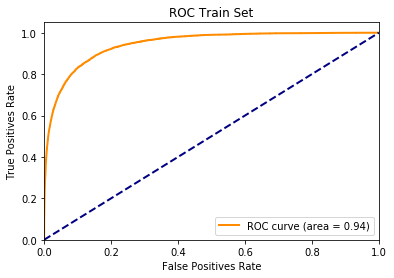

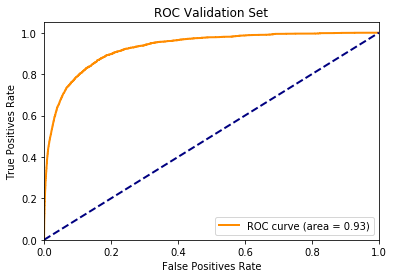

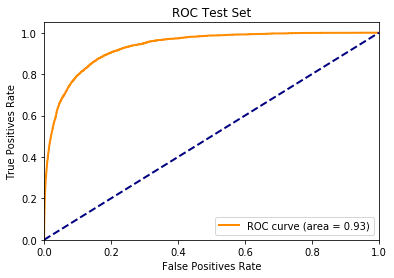

In [36]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Train Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Validation Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Test Set')
plt.legend(loc="lower right")
plt.show()

In [37]:
# confusion matrix:
# tn  fp
# fn  tp
# -------
# f1 score: tp / (tp + (fp + fn)/2)
# -------
# acuracy score: (tp + tn) / (tp + fp + tn + fn)
# -------
# recall score: tp / (tp + fn)
# -------
# precision score: tp / (tp + fp)

cm_train = confusion_matrix(train_y, train_pred)
cm_val = confusion_matrix(val_y, val_pred)
cm_test = confusion_matrix(test_y, test_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()
cm_val_pct = cm_val / cm_val.astype(np.float).sum()
cm_test_pct = cm_test / cm_test.astype(np.float).sum()

summary = [
    ['------', 'Train', 'Validation', 'Test'],
    ['confusion matrix', cm_train, cm_val, cm_test],
    ['confusion matrix pct', cm_train_pct, cm_val_pct, cm_test_pct],
    ['f1 score', f1_score(train_y, train_pred), f1_score(val_y, val_pred), f1_score(test_y, test_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(val_y, val_pred), accuracy_score(test_y, test_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(val_y, val_pred), recall_score(test_y, test_pred)],
    ['precision score', precision_score(train_y, train_pred), precision_score(val_y, val_pred), precision_score(test_y, test_pred)]
]

pretty_table(summary)

------              	Train                    	Validation               	Test                     
confusion matrix    	[[241733   3707]         	[[80267  1330]           	[[80112  1410]           
                    	 [  4723   5337]]        	 [ 1750  1612]]          	 [ 1744  1562]]          
confusion matrix pct	[[0.94611742 0.01450881] 	[[0.94477336 0.01565461] 	[[0.94440515 0.01662187] 
                    	 [0.01848532 0.02088845]]	 [0.02059817 0.01897386]]	 [0.02055925 0.01841373]]
f1 score            	0.5587311557788945       	0.5114213197969543       	0.49761070404587454      
accuracy score      	0.9670058708414873       	0.9637472192469309       	0.9628188805583062       
recall score        	0.5305168986083499       	0.47947650208209397      	0.4724742891712039       
precision score     	0.5901149933657673       	0.5479265805574439       	0.5255720053835801       
